# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [79]:
# 1. Gerekli kütüphaneleri yükle
import os
import json
import random
import string
from datetime import datetime
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr


In [80]:
# 2. Ortam değişkenlerini yükle
load_dotenv(override=True)
openai = OpenAI()
MODEL = "gpt-4o-mini"


In [81]:
# 3. Uçak bileti fiyatları sözlüğü (çift şehirli anahtarlarla)
ticket_prices = {
    ("istanbul", "berlin"): "$499",
    ("istanbul", "tokyo"): "$1400",
    ("ankara", "berlin"): "$550",
    ("izmir", "tokyo"): "$1350",
    ("antalya", "paris"): "$790",
    ("istanbul", "paris"): "$899"
}


In [82]:
# 4. Bilet fiyatı fonksiyonu (güvenli)
def get_ticket_price(departure_city, destination_city):
    """
    departure_city ve destination_city ikilisini kullanarak
    ticket_prices sözlüğünden bakar, yoksa tek şehre bakar.
    """
    dep = departure_city.lower()
    dest = destination_city.lower()
    # Önce çift anahtara bak
    price = ticket_prices.get((dep, dest))
    if price:
        return price
    # Çift anahtar yoksa, tek şehre de bakabilirsin
    return ticket_prices.get(dest, "Unknown")


In [83]:
# 5. PNR üretici & rezervasyon fonksiyonu (tarih destekli)
def generate_pnr():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))

def make_reservation(departure_city, destination_city, travel_date):
    pnr = generate_pnr()
    # travel_date format 'YYYY-MM-DD'
    try:
        fly_date = datetime.fromisoformat(travel_date)
        date_str = fly_date.strftime("%d %B %Y")
    except:
        date_str = travel_date
    return (
        f"Your reservation from {departure_city.title()} to {destination_city.title()} on {date_str} is confirmed.\n"
        f"Flight departs at 13:45 local time.\n"
        f"Reservation Code (PNR): {pnr}.\n"
        f"Seat selection will be available during check-in."
    )

In [84]:
# 6. Fonksiyon sarmalayıcıları
def get_ticket_price_fn(departure_city: str, destination_city: str) -> str:
    return get_ticket_price(departure_city, destination_city)

def make_reservation_fn(departure_city: str, destination_city: str, travel_date: str) -> str:
    return make_reservation(departure_city, destination_city, travel_date)


In [85]:

# 7. Fonksiyon tanımları
functions = [
    {
        "name": "get_ticket_price",
        "description": "Returns the ticket price between a departure and destination city.",
        "parameters": {
            "type": "object",
            "properties": {
                "departure_city": {"type": "string", "description": "Departure city."},
                "destination_city": {"type": "string", "description": "Destination city."}
            },
            "required": ["departure_city", "destination_city"]
        }
    },
    {
        "name": "make_reservation",
        "description": "Reserves a flight from departure to destination city on a given date and returns reservation details.",
        "parameters": {
            "type": "object",
            "properties": {
                "departure_city": {"type": "string", "description": "Departure city."},
                "destination_city": {"type": "string", "description": "Destination city."},
                "travel_date": {"type": "string", "description": "Travel date in YYYY-MM-DD format."}
            },
            "required": ["departure_city", "destination_city", "travel_date"]
        }
    }
]

In [86]:
# 8. Sistem mesajı
system_message = (
    "You are a helpful assistant for an airline called FlightAI. "
    "Never call any functions unless both the departure city, destination city, and travel date are clearly provided. "
    "If the user mentions only destination or departure, ask for the missing details. "
    "Ask explicitly for travel date in YYYY-MM-DD format."
)


In [87]:

# 9. Ana sohbet fonksiyonu
import json

def chat(history):
    # 1) Sistem + geçmiş
    msgs = [{"role":"system","content":system_message}] + history

    # 2) İlk çağrı: functions parametresiyle
    response = openai.chat.completions.create(
        model=MODEL,
        messages=msgs,
        functions=functions      # not tools!
    )
    msg = response.choices[0].message

    # 3) Eğer gerçekten fonksiyon çağrısı geldiyse
    if response.choices[0].finish_reason == "function_call" and msg.function_call:
        fc = msg.function_call
        args = json.loads(fc.arguments)

        # 3a) Yerel fonksiyonu çalıştır
        if fc.name == "get_ticket_price":
            result = get_ticket_price_fn(**args)
        elif fc.name == "make_reservation":
            result = make_reservation_fn(**args)
        else:
            result = f"Unknown function: {fc.name}"

        # 3b) Asistanın function_call bilgisini ekle
        msgs.append({
            "role": "assistant",
            "content": None,
            "function_call": {
                "name": fc.name,
                "arguments": fc.arguments
            }
        })

        # 3c) “function” rolüyle gerçek yanıtı ekle
        msgs.append({
            "role": "function",
            "name": fc.name,
            "content": json.dumps(result)
        })

        # 3d) Son API çağrısı: nihai metni al
        followup = openai.chat.completions.create(
            model=MODEL,
            messages=msgs
        )
        reply = followup.choices[0].message.content

    else:
        # 4) Normal metin cevabı
        reply = msg.content

    # 5) Geçmişi güncelle, isteğe bağlı ses/görsel fonksiyonları
    history.append({"role":"assistant","content":reply})
    talker(reply)      # eğer kalmasını istiyorsan
    return history, None



In [88]:
# 10. Gradio arayüzünü başlat
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7883

To create a public link, set `share=True` in `launch()`.


In [89]:
# FlightAI Tool Calling Demo for Jupyter Notebook

# Cell 1: Imports and API setup
from dotenv import load_dotenv
import os
import json
import uuid
from openai import OpenAI
import gradio as gr


In [90]:
# Load environment variables and initialize OpenAI client
load_dotenv(override=True)
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OpenAI API key not found in environment")
openai = OpenAI()
MODEL = "gpt-4o-mini"


In [91]:
# Cell 2: Demo Data
# Ticket prices for demonstration purposes
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}
# Flight schedule data without dates for simplicity
flight_schedule = [
    {"from": "istanbul", "to": "paris", "time": "08:30"},
    {"from": "istanbul", "to": "paris", "time": "15:45"},
    {"from": "istanbul", "to": "berlin", "time": "09:15"},
    {"from": "ankara", "to": "paris", "time": "11:00"}
]


In [92]:
# Cell 3: Tool Functions
def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    return ticket_prices.get(destination_city.lower(), "Unknown")

# def get_flight_time(departure_city, destination_city):
#     print(f"Tool get_flight_time called for {departure_city}->{destination_city}")
#     dep = departure_city.lower()
#     dest = destination_city.lower()
#     for f in flight_schedule:
#         if f["from"] == dep and f["to"] == dest:
#             return f["time"]
#     return "No flights found"

import random

def get_flight_time(departure_city, destination_city):
    dep = departure_city.lower()
    dest = destination_city.lower()
    # Tarifedeki saatleri bul
    times = [
        f["time"]
        for f in flight_schedule
        if f["from"] == dep and f["to"] == dest
    ]
    if times:
        return random.choice(times)

    # Fallback: rota olmasa bile sabit bir saat döndür
    return "12:00"

def book_flight(departure_city, destination_city, date, passenger_name):
    print(f"Tool book_flight called for {departure_city}->{destination_city} on {date} for {passenger_name}")
    time = get_flight_time(departure_city, destination_city)
    price = get_ticket_price(destination_city)
    if time.startswith("No"):
        return {"status": "error", "message": "No flights available"}
    pnr = str(uuid.uuid4())[:6].upper()
    return {
        "status": "ok",
        "departure_city": departure_city,
        "destination_city": destination_city,
        "date": date,
        "time": time,
        "price": price,
        "passenger_name": passenger_name,
        "pnr": pnr
    }

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [93]:
# Cell 4: Tool Schemas
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {"type": "string", "description": "The city that the customer wants to travel to"}
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

flight_time_function = {
    "name": "get_flight_time",
    "description": "Get the departure time for a flight between two cities.",
    "parameters": {
        "type": "object",
        "properties": {
            "departure_city": {"type": "string", "description": "The city the passenger is flying from"},
            "destination_city": {"type": "string", "description": "The city the passenger wants to fly to"}
        },
        "required": ["departure_city", "destination_city"],
        "additionalProperties": False
    }
}

book_flight_function = {
    "name": "book_flight",
    "description": "Book a flight given departure, destination, date and passenger name; returns booking details.",
    "parameters": {
        "type": "object",
        "properties": {
            "departure_city": {"type": "string", "description": "Departure city"},
            "destination_city": {"type": "string", "description": "Destination city"},
            "date": {"type": "string", "description": "Travel date in YYYY-MM-DD"},
            "passenger_name": {"type": "string", "description": "Name of the passenger"}
        },
        "required": ["departure_city", "destination_city", "date", "passenger_name"],
        "additionalProperties": False
    }
}

tools = [
    price_function,
    flight_time_function,
    book_flight_function
]


In [94]:
# Cell 5: System Message
system_message = (
    "You are a FlightAI assistant. When the user provides departure, destination, and date, "
    "first call get_flight_time and get_ticket_price to fetch time and price, "
    "then ask for confirmation and passenger name. Only after confirmation, call book_flight."
)

In [95]:
# Cell 6: Tool Call Handler
import json

def handle_tool_call(message):
    """
    message: response.choices[0].message
    """
    # 1) .function_call’dan adı ve argümanları al
    fc = message.function_call
    name = fc.name
    args = json.loads(fc.arguments)

    # 2) Gerçek fonksiyonu çalıştır
    if name == "get_ticket_price":
        result = get_ticket_price_fn(**args)
    elif name == "make_reservation":
        result = make_reservation_fn(**args)
    else:
        result = f"Error: unknown function {name}"

    # 3) Asistan cevabı formatında döndür
    return {
        "role": "assistant",
        "content": result
    }


In [96]:
# Cell 7: Chat Function
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, functions=tools)
    # Handle all tool calls
    while response.choices[0].finish_reason == "tool_calls":
        tool_msg = response.choices[0].message
        messages.append(tool_msg)
        for tc in tool_msg.tool_calls:
            tool_response = handle_tool_call(tc)
            messages.append(tool_response)
        response = openai.chat.completions.create(model=MODEL, messages=messages, functions=tools)
    return response.choices[0].message.content

In [97]:

# Cell 8: Launch Gradio Interface
gr.ChatInterface(fn=chat, type="messages", title="FlightAI Demo").launch()


* Running on local URL:  http://127.0.0.1:7884

To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [98]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [99]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

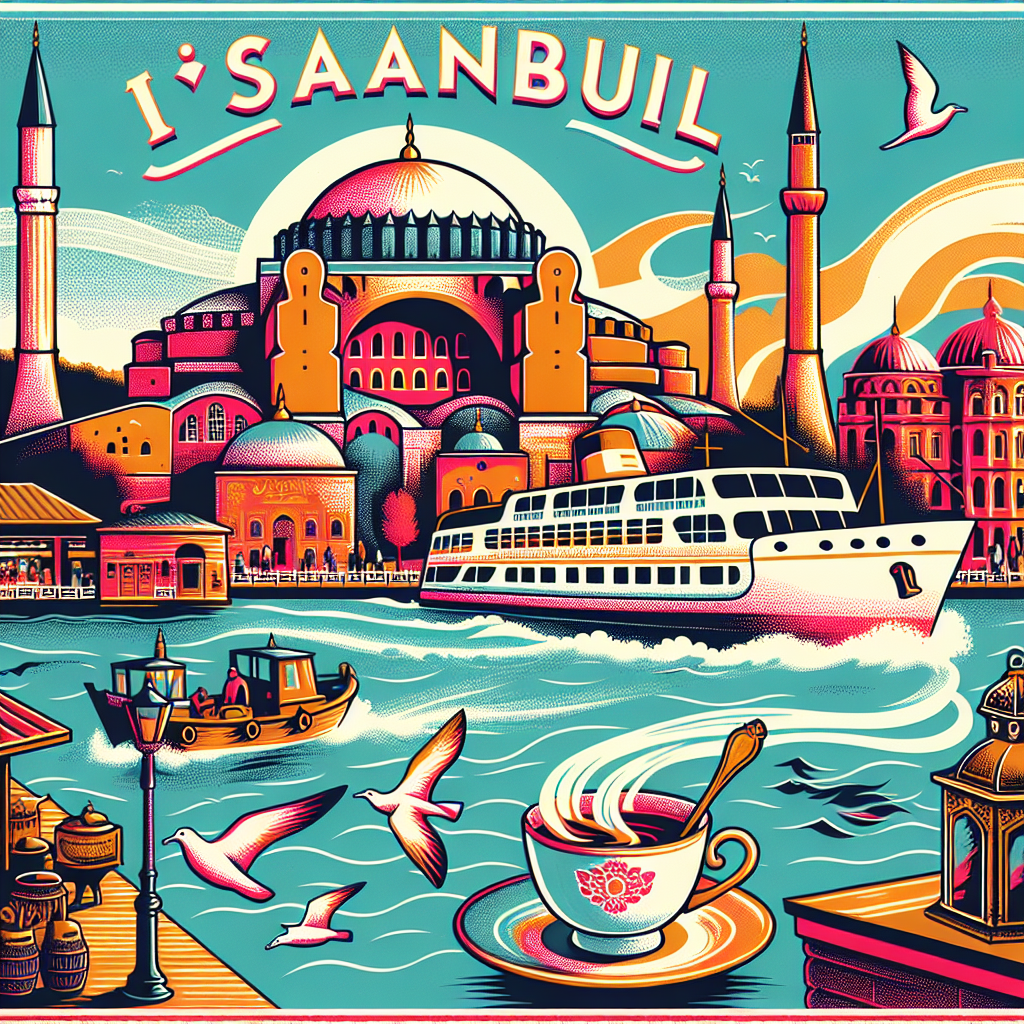

In [14]:
image = artist("İstanbul")
display(image)

## Audio (NOTE - Audio is optional for this course - feel free to skip Audio if it causes trouble!)

And let's make a function talker that uses OpenAI's speech model to generate Audio

### Troubleshooting Audio issues

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For PC Users**

Detailed instructions are [here](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) and summary instructions:

1. Download FFmpeg from the official website: https://ffmpeg.org/download.html

2. Extract the downloaded files to a location on your computer (e.g., `C:\ffmpeg`)

3. Add the FFmpeg bin folder to your system PATH:
- Right-click on 'This PC' or 'My Computer' and select 'Properties'
- Click on 'Advanced system settings'
- Click on 'Environment Variables'
- Under 'System variables', find and edit 'Path'
- Add a new entry with the path to your FFmpeg bin folder (e.g., `C:\ffmpeg\bin`)
- Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes

4. Open a new command prompt and run this to make sure it's installed OK
`ffmpeg -version`

**For Mac Users**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

Message me or email me at ed@edwarddonner.com with any problems!

In [100]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="alloy",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Welcome to Paris")

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [101]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, functions=tools)
    image = None
    
    if response.choices[0].finish_reason=="function_call":
        message = response.choices[0].message
        response, city = handle_tool_call(message);
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [102]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.


# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>